In [573]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy import integrate

import mplcyberpunk

In [574]:
plt.style.use('cyberpunk')
#mplcyberpunk.make_lines_glow()

The luminic distance is defined by:

$$d_L(z) = (1+z) \int_0^z \frac{dz'}{H(z')}$$

as a differenftial equation the above integral can be written as:

$$u(z) =  \int_0^z \frac{dz'}{H(z')} \implies \frac{du}{dz} = \frac{1}{H(z)}$$

In the other hand, the hubble parameter can be written in the parametric form:

$$H(z) = H_0 \sqrt{\Omega_{m,0} (1+z)^3 + \Omega_{r,0} (1+z)^4 + \Omega_{\Lambda,0}} $$

where:


$$
\begin{align}
    H_0 = 70 \\
    \Omega_m = 0.3 \\
    \Omega_r = 1 \times 10^{-5} \\
    \Omega_{\Lambda} = 0.7.
\end{align}
$$


The reparametrization to enforce the initial conditions is:

$$\hat{u}_{nn} = H_0 + (1-e^{-(z-z_0)})u_{nn}(z)$$

---

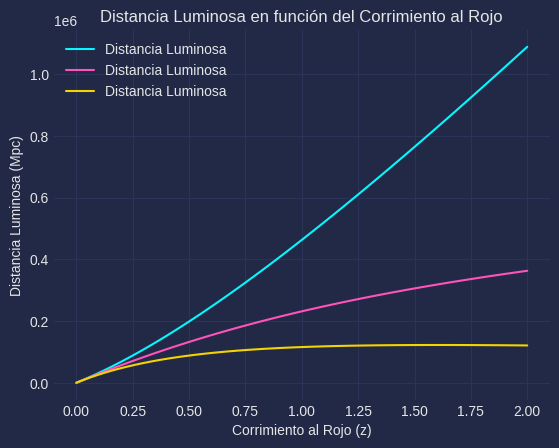

In [575]:
# Constantes cosmológicas
H0 = 70.0  # constante de Hubble en km/s/Mpc
c = 3.0e5  # velocidad de la luz en km/s
Omega_m = 0.3  # densidad de materia
Omega_Lambda = 0.7  # densidad de energía oscura
Omega_r = 1e-5

# Función para la integración numérica
def integrand(z):
    return H0 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda + Omega_r*(1+z)**4)

# Función para calcular la distancia luminosa
def luminosity_distance(z):
    integral, _ = integrate.quad(integrand, 0, z)
    return (c / H0) * (1 + z) * integral

# Vector de corrimiento al rojo
redshifts = np.linspace(zi, zf, 100)

# Calcular distancias luminosas para cada corrimiento al rojo
distances = np.array([luminosity_distance(z) for z in redshifts])

# Graficar resultados
plt.plot(redshifts, distances, label='Distancia Luminosa')
plt.plot(redshifts, distances/(redshifts+1), label='Distancia Luminosa')
plt.plot(redshifts, distances/(redshifts+1)**2, label='Distancia Luminosa')
plt.xlabel('Corrimiento al Rojo (z)')
plt.ylabel('Distancia Luminosa (Mpc)')
plt.title('Distancia Luminosa en función del Corrimiento al Rojo')
plt.legend()
plt.grid(True)
plt.show()

In [576]:
#i) A function to get the derivative of the neural network
def nth_derivative(net, x, n):
    # Initialize the gradient tensor to 1.0, as the 0th derivative is the function itself.
    grad_tensor = torch.ones_like(x, requires_grad=True)

    for _ in range(n):
        # Compute the gradient of the network's output with respect to the input.
        grad_tensor = torch.autograd.grad(net(x), x, grad_outputs=grad_tensor, create_graph=True)[0]

    return grad_tensor

In [577]:
#1 Define the fucntion that describes the differential equation F(t;x,x',...)=0
H_0 = 70
Omega_m = 0.3
Omega_r = 1e-5
Omega_L = 0.7
def H_radius(net,z):
    H_0 = 70
    Omega_m = 0.3
    Omega_r = 1e-5
    Omega_L = 0.7
    
    H = torch.sqrt(Omega_m*(1+z)**3 + Omega_r*(1+z)**4 + Omega_L)
    return nth_derivative(net, z, 1) - H0/H

In [578]:
#architecture

nodos=40
ANN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=40, bias=True)
  (1): Tanh()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): Tanh()
  (4): Linear(in_features=40, out_features=1, bias=True)
)


In [579]:
# Now the re-parametrization of the network, depends on the initial conditions
def ReParam_D(t,net=ANN):
    #a=(t-ti)*v0
    b=(1-torch.exp(zi-t))
    return Dl_0 + b*net(t)

In [580]:
#Now the cost function
def cost(t):
    t.requires_grad=True
    #calculamos una salida de la red
    return torch.linalg.norm(H_radius(ReParam_D,t))

In [581]:
#5 el intervalo que queremos para x
puntos=60
zi=0.0
zf=2.0
Dl_0=0

z = torch.linspace(zi,zf,puntos)
z=z.reshape(puntos,1)

In [582]:
#4 Error and optimizer
learning_rate=0.01
epocas=1000

#optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
optimizer=optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

época=999.00 , loss=0.61


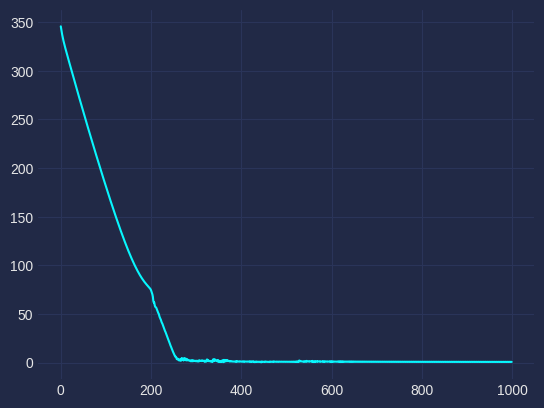

In [583]:
#loop de entrenamiendo 
errores=[]
for i in range(epocas):
    l=cost(z) #coste
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
print('época=%.2f , loss=%.2f'%(i,l))
plt.plot(range(epocas),errores)


In [584]:
plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["FreeMono"]

findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.


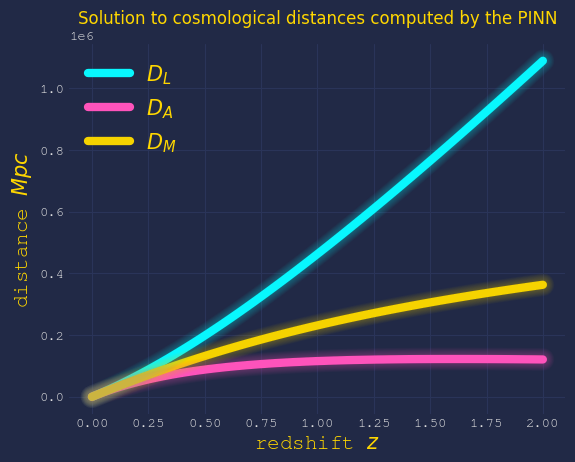

In [593]:
x = torch.linspace(zi,zf,100)
x=x.reshape(100,1)
#plt.plot(x,x**2,'ro')
#plt.plot(x,2-torch.cos(x),label='Analitic solution')
plt.plot(x,(c / H0)*(1+x)*ReParam_D(x,net=ANN).detach().numpy(), label='$D_L$', linewidth=6)
plt.plot(x,(c / H0)*1/(1+x)*ReParam_D(x,net=ANN).detach().numpy(), label='$D_A$', linewidth=6)
plt.plot(x,(c / H0)*ReParam_D(x,net=ANN).detach().numpy(), label='$D_M$', linewidth=6)
#plt.plot(redshifts, distances,'--' ,label='Distancia Luminosa')
# Graficar resultados
plt.xlabel('redshift $z$', color='gold', size=15)
plt.ylabel('distance $Mpc$',color='gold', size=15)
plt.title('Solution to cosmological distances computed by the PINN', color='gold',fontname='Franklin Gothic Medium')
plt.legend(labelcolor='gold',fontsize=15)
mplcyberpunk.make_lines_glow()
plt.savefig('distances.png')

---

The Poisson equation:

$$\nabla\Phi = 4\pi G \rho(r)$$

Let's work in spherical coordiates and we can assume spherical simetry:


Then the equation becomes: 

$$\frac{1}{r^2}\frac{d}{dr} \left(r^2 \frac{d}{dr} \Phi \right)= 4\pi G \rho(r)$$

with the conditions:

$$\rho(r) = \frac{\rho_0}{r^2}$$
$$\Phi'(r)=0 $$
$$\Phi(r=0) = 1$$

In [533]:
nodos=40
NN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,1))
print(NN)

Sequential(
  (0): Linear(in_features=1, out_features=40, bias=True)
  (1): Tanh()
  (2): Linear(in_features=40, out_features=40, bias=True)
  (3): Tanh()
  (4): Linear(in_features=40, out_features=40, bias=True)
  (5): Tanh()
  (6): Linear(in_features=40, out_features=1, bias=True)
)


In [534]:
G = 6.67e-11 #N*m/Kg²
rho0 = 1.6e5 #kg/m3
x0 = 0
v0 = 1.0
c=4*torch.pi*G*rho0
#c=1.0
def ReParam(t,net=NN):
    #a=(t-ti)*v0
    b=1-torch.exp(ti-t)
    return x0 + b*net(t)

In [535]:
#1 Define the fucntion that describes the differential equation F(t;x,x',...)=0
def poisson(net,t):
    return nth_derivative(net, t, 2) + 2/t*nth_derivative(net, t, 1) - c/t**2

In [536]:
def cost(t):
    t.requires_grad=True
    #calculamos una salida de la red

    return torch.linalg.norm(poisson(ReParam,t))

In [542]:
#4 Error and optimizer
learning_rate=0.01
epocas=800

#optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
optimizer=optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

In [543]:
#5 el intervalo que queremos para x
puntos=200
x = torch.linspace(1,20,puntos)
x=x.reshape(puntos,1)

época=799.00 , loss=0.00072


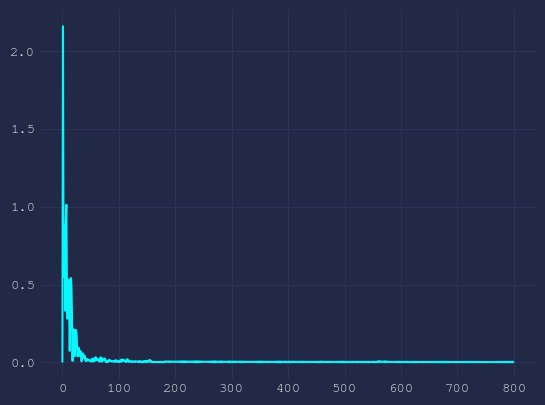

In [544]:
#loop de entrenamiendo
ti=1.0

errores=[]
for i in range(epocas):
    l=cost(x) #coste
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
print('época=%.2f , loss=%.5f'%(i,l))
plt.plot(range(epocas),errores)


In [595]:
x = torch.linspace(1,20,100)
x=x.reshape(100,1)
k1=c/3.0-1
k2=-c/2.0+1
real = c*x**2 *1/6 + k1/x + k2

findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.
findfont: Font family 'Franklin Gothic Medium' not found.


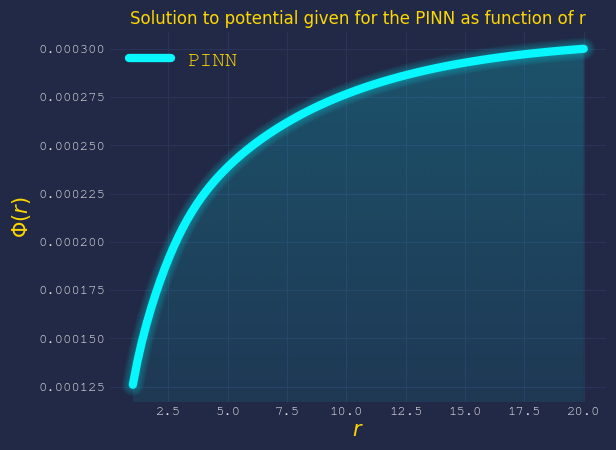

In [606]:
plt.plot(x,ReParam(x,net=NN).detach().numpy(), label='PINN',linewidth=6)
plt.xlabel('$r$', color='gold', size=15)
plt.ylabel('$\Phi(r)$',color='gold', size=15)
#plt.title('Distancia Luminosa en función del Corrimiento al Rojo', color='gold',fontname='Franklin Gothic Medium')
plt.legend(labelcolor='gold',fontsize=15)
plt.title('Solution to potential given for the PINN as function of r', color='gold',fontname='Franklin Gothic Medium')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_gradient_fill(alpha_gradientglow=0.2, gradient_start='zero')
plt.savefig('poisson.png')

---


In [ ]:
x = torch.linspace(zi,zf,100)
x=x.reshape(100,1)

In [590]:
%%timeit
(c / H0)*(1+x)*ReParam_D(x,net=ANN).detach().numpy()
(c / H0)*1/(1+x)*ReParam_D(x,net=ANN).detach().numpy()
(c / H0)*ReParam_D(x,net=ANN).detach().numpy();

1.19 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [591]:
%%timeit
distances = np.array([luminosity_distance(z) for z in redshifts])
distances/(redshifts+1)
distances/(redshifts+1)**2


5.73 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [612]:
1.19*100/5.13

23.196881091617936